Here we will have a look at OpenCV image pyramid functions and compare them with our own functions.

The OpenCV functions are described here: https://docs.opencv.org/3.4/d4/d1f/tutorial_pyramids.html

In [1]:
# Imports
import PIL
import io
import cv2
import matplotlib.pyplot as plt
from IPython import display
import time
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import math
from numpy.lib.stride_tricks import as_strided

# Logging
import logging
logging.basicConfig(level=logging.INFO)

from skimage.data import chelsea, astronaut, coffee

ModuleNotFoundError: No module named 'skimage'

In [2]:
def showarray(a, fmt='jpeg'):
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display.display(display.Image(data=f.getvalue()))

def separate_components(frame, square=True):
    """Separate frame into YUV components.
    
    square - boolean - if true subsample the colour images so they are square
    """
    if square:
        return frame[:,:,0], frame[::2, 1::2, 1], frame[::2, 0::2, 1]
    else:
        return frame[:,:,0], frame[:, 1::2, 1], frame[:, 0::2, 1]

def stage(image):
    """Smooth an image so as to downsample.
    
    image - numpy array"""
    stage1 = gaussian_filter(image, 1)
    stage2 = gaussian_filter(stage1, math.sqrt(2))
    return stage2

def tile_array(a, b0, b1):
    """Tile array a in blocks of size b0 * b1"""
    r, c = a.shape                                    # number of rows/columns
    rs, cs = a.strides                                # row/column strides 
    x = as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0)) # view a as larger 4D array
    return x.reshape(r*b0, c*b1)                      # create new 2D array

def make_square(image):
    """Crop an image so it is square and a power of 2.
    
    image - numpy array"""
    rows, cols = image.shape
    diff = rows - cols
    if diff > 0:
        image = image[diff//2:-diff//2, :]
    elif diff < 0:
        image = image[:, abs(diff)//2:-abs(diff)//2]
    return image

def reduce_to_2(image, reduce="centre"):
    """Reduce image size to a square that is a factor of 2."""
    rows, cols = image.shape
    smallest = min((rows, cols))
    scales = int(math.log2(rows))
    size = 2**scales
    row_diff = rows - size
    col_diff = cols - size
    # Watch out for when array is well-formed
    upper_row = rows
    lower_row = 0
    upper_col = cols
    lower_col = 0
    if row_diff:
        upper_row = -row_diff//2
        lower_row = row_diff//2
    if col_diff:
        # This is needed when processing left/right visual fields
        if reduce == "centre":
            # Crop either side of the centre
            upper_col = -col_diff//2
            lower_col = col_diff//2
        elif reduce == "left":
            # Crop from the left
            lower_col = col_diff
        elif reduce == "right":
            # Crop from the right
            upper_col = -col_diff
    return image[lower_row:upper_row, lower_col:upper_col]
    
def normalise(array):
    """Scale array between 0 and 255"""
    min_array = array.min()
    max_array = array.max()
    new_array = ((array - min_array) / (max_array - min_array))*255
    return new_array

def build_cascade(image, norm=False, reduce="centre"):
    """Smooth and subtract images at different scales.
    
    image - numpy array"""
    image = reduce_to_2(image, reduce)
    rows, cols = image.shape
    #scales = int(math.log2(rows))
    scales = rows.bit_length()
    # Generate a new tensor - 0 holds the blurred images, 1 the differences
    processed = np.zeros(shape=(rows, cols, scales, 2), dtype=np.uint8)
    current_image = image
    processed[:, :, 0, 0] = current_image
    # Generate Blurs
    for i in range(1, scales):
        #logging.info(f"Current image shape: {current_image.shape}")
        #logging.info(f"Scale: {2**i}")
        blurred = stage(current_image).astype(np.uint8)
        #logging.info(f"Shape of blurred image: {blurred.shape}")
        # Save downsampled array in processed
        processed[::(2**i), ::(2**i), i, 0] = blurred[::2, ::2]
        processed[:, :, i, 0] = tile_array(processed[::(2**i), ::(2**i), i, 0], (2**i), (2**i))
        current_image = processed[::(2**i), ::(2**i), i, 0]
    # Iterate through scales determining differences
    for j in range(0, scales-1):
        processed[:, :, j, 1] = processed[:, :, j+1, 0] - processed[:, :, j, 0] + 128
        if norm:
            processed[:, :, j, 1] = normalise(processed[:, :, j, 1])
    # Take last level as just the processed - 0 (i.e. one image with all zeros)
    processed[:, :, scales-1, 1] = processed[:, :, scales-1, 0]
    return processed

def build_image(image_array):
    """Build a single image from stacked multiple images.
    
    image_array - ND numpy array [rows, cols, scales, blur/diff index]."""
    rows, cols, scales, dims = image_array.shape
    # Put blurred on top
    flattened_top = image_array[:,:,:,0].swapaxes(1,2).reshape(rows, -1)
    # Put differences on bottom
    flattened_bottom = image_array[:,:,:,1].swapaxes(1,2).reshape(rows, -1)
    # Stack vertically
    flattened = np.concatenate((flattened_top, flattened_bottom))
    return flattened

def split_vertical(processed):
    """Split a series of processed image into upper and lower visual fields."""
    rows, cols, scales, diffs = processed.shape
    # Initialise arrays for upper and lower
    # upper = np.zeros(shape=(rows, cols//2, scales, diffs), dtype=np.uint8)
    # lower = np.zeros(shape=(rows, cols//2, scales, diffs), dtype=np.uint8)
    # Scales - 1 as last scale is a single value 
    lower = processed[:, :cols//2, :-1, :]
    upper = processed[:, cols//2:, :-1, :]
    return upper, lower

def mirror(processed, odd=True):
    """Mirror odd images in array."""
    rows, cols, scales, diffs = processed.shape
    result = processed.copy() 
    if odd:
        offset = 0
    else:
        offset = 1
    for i in range(0, scales):
        if (i+offset)%2:
            result[:, :, i, :] = np.fliplr(processed[:, :, i, :])       
    return result

# From here - https://stackoverflow.com/questions/9924135/fast-cartesian-to-polar-to-cartesian-in-python
def polar2cart(r, theta, center):

    x = r  * np.cos(theta+np.pi/2) + center[0]
    y = r  * np.sin(theta+np.pi/2) + center[1]
    return x, y

def generateLUT(center, final_radius, phase_width = 256):
    initial_radius = 0
    theta , R = np.meshgrid(np.linspace(0, 2*np.pi, phase_width), 
                            np.arange(initial_radius, final_radius))

    Xcart, Ycart = polar2cart(R, theta, center)

    Xcart = Xcart.astype(int)
    Ycart = Ycart.astype(int)
    return (Xcart, Ycart)

def img2polar(img, center, final_radius, LUT, phase_width = 256):

    Xcart, Ycart = LUT
    if img.ndim ==3:
        polar_img = img[Ycart,Xcart,:]
        polar_img = np.reshape(polar_img,(final_radius, phase_width,3))
    else:
        polar_img = img[Ycart,Xcart]
        polar_img = np.reshape(polar_img,(final_radius, phase_width))

    return polar_img

## OpenCV Functions

In [3]:
# Just use red channel
current_image = chelsea()[:,:,0]

In [4]:
%%timeit 
blurred1 = stage(current_image).astype(np.uint8)[::2, ::2]

3.68 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


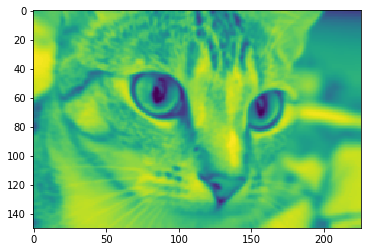

In [5]:
blurred1 = stage(current_image).astype(np.uint8)[::2, ::2]
plt.imshow(blurred1)

In [6]:
%%timeit 
blurred2 = cv2.pyrDown(current_image, (current_image.shape[0]//2, current_image.shape[1]//2))

111 µs ± 608 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


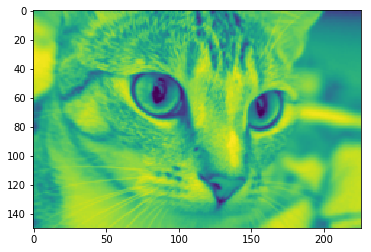

In [7]:
blurred2 = cv2.pyrDown(current_image, (current_image.shape[0]//2, current_image.shape[1]//2))
plt.imshow(blurred2)

In [8]:
blurred2.dtype

dtype('uint8')

### Trying Additional Separable 1D Numpy Convolution

In [10]:
def conv_2D(signal, kernel):
    # Flatten along each axis and convolve
    # rows
    flattened = signal.flatten()
    convolved_row = np.convolve(flattened, kernel, mode="same") 
    reshaped = convolved_row.reshape(signal.shape)
    # columns
    flattened = reshaped.flatten(order="F")
    convolved_row = np.convolve(flattened, kernel, mode="same") 
    reshaped = convolved_row.reshape(signal.shape, order="F")
    return reshaped.astype(np.uint8)

def pyr_down(image):
    """Custom pyramid down function based on Crowley."""
    kernel_1 = np.asarray([1, 4, 6, 4, 1], dtype=np.uint8)
    kernel_2 = np.convolve(kernel_1, kernel_1)
    kernel_1 = kernel_1 / kernel_1.sum()
    kernel_2 = kernel_2 / kernel_2.sum()
    first_convolve = conv_2D(image, kernel_1)
    second_convolve = conv_2D(first_convolve, kernel_2)
    return second_convolve[::2, ::2]

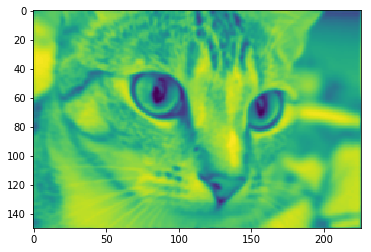

In [11]:
blurred3 = pyr_down(current_image)
plt.imshow(blurred3)
plt.show()

In [12]:
%timeit blurred3 = pyr_down(current_image)

3.53 ms ± 33.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So similar to the original stage function...

What if we take the kernels out the loop?

In [15]:
kernel_1 = np.asarray([1, 4, 6, 4, 1], dtype=np.uint8)
kernel_2 = np.convolve(kernel_1, kernel_1)
kernels = [kernel_1 / kernel_1.sum(), kernel_2 / kernel_2.sum()]

def pyr_down_2(image, kernels):
    """Custom pyramid down function based on Crowley."""
    first_convolve = conv_2D(image, kernels[0])
    second_convolve = conv_2D(first_convolve, kernels[1])
    return second_convolve[::2, ::2]

In [16]:
%timeit blurred3 = pyr_down_2(current_image, kernels)

3.53 ms ± 85.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


No - not much difference in declaring the kernels outside of the loop.

### Using OpenCV Filters

There are a number of other filters in OpenCV. https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html#filtering

In [20]:
import math

def pyr_down_3(image):
    """Custom pyramid down function based on Crowley."""
    first_convolve = cv2.GaussianBlur(image,(5,5), 1)
    second_convolve = cv2.GaussianBlur(first_convolve, (9,9), math.sqrt(2))
    return second_convolve[::2, ::2]

In [21]:
blurred4 = pyr_down_3(current_image)

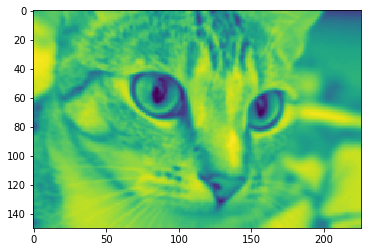

In [22]:
plt.imshow(blurred4)
plt.show()

In [23]:
%timeit blurred4 = pyr_down_3(current_image)

270 µs ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Using the FFT to Convolve?

As per here - https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy

In [17]:
from numpy.fft import fft2, ifft2
import numpy as np

def fft_convolve2d(x,y):
    """ 2D convolution, using FFT"""
    fr = fft2(x)
    fr2 = fft2(np.flipud(np.fliplr(y)))
    m,n = fr.shape
    cc = np.real(ifft2(fr*fr2))
    cc = np.roll(cc, -m/2+1,axis=0)
    cc = np.roll(cc, -n/2+1,axis=1)
    return cc

In [ ]:
def fft_pyr_down(image)

### Testing on Video

In [24]:
def build_cascade2(image, norm=False, reduce="centre"):
    """Smooth and subtract images at different scales.
    
    image - numpy array"""
    image = reduce_to_2(image, reduce)
    rows, cols = image.shape
    #scales = int(math.log2(rows))
    scales = rows.bit_length()
    # Generate a new tensor - 0 holds the blurred images, 1 the differences
    processed = np.zeros(shape=(rows, cols, scales, 4), dtype=np.uint8)
    current_image = image
    processed[:, :, 0, 0] = current_image
    # Generate Blurs
    for i in range(1, scales):
        #logging.info(f"Current image shape: {current_image.shape}")
        #logging.info(f"Scale: {2**i}")
        blurred = cv2.pyrDown(current_image, (current_image.shape[0]//2, current_image.shape[1]//2))
        #logging.info(f"Shape of blurred image: {blurred.shape}")
        # Save downsampled array in processed
        processed[:, :, i, 0] = tile_array(blurred, (2**i), (2**i))
        current_image = blurred
    # Iterate through scales determining differences
    for j in range(0, scales-1):
        # Positive differences
        diff = (processed[:, :, j+1, 0] - processed[:, :, j, 0]).astype(np.int8)
        #RELU
        processed[:, :, j, 1] = np.digitize(diff, [0, 10, 127])-1
        # Negative differences
        processed[:, :, j, 2] = np.digitize(-1*diff, [0, 10, 127])-1
    # Take last level as just the processed - 0 (i.e. one image with all zeros)
    processed[:, :, scales-1, 1] = processed[:, :, scales-1, 0]
        
    # Reconstruct image from differences
    processed[:, :, scales-1, 3] = processed[:, :, scales-1, 0]
    for k in range(scales-2, -1, -1):
        processed[:, :, k, 3] = processed[:, :, k+1, 3] - processed[:, :, k, 1]*5 + processed[:, :, k, 2]*5
    
    return processed

In [29]:
cam.release()

In [10]:
cam = cv2.VideoCapture(0)
cam.set(16, 0)
ret, frame = cam.read()
if ret:
    #print("Separating components")
    Y, V, U = separate_components(frame)
    processed = build_cascade2(Y)
cam.release()

In [11]:
ret

True

In [13]:
processed.shape

(256, 256, 9, 2)

In [28]:
cam = cv2.VideoCapture(0)
cam.set(16, 0)

try:
    while True:
        
        # Capture frame-by-frame
        ret, frame = cam.read()
        if ret:
            #print("Separating components")
            Y, V, U = separate_components(frame)
            #print("Splitting Visual Field and Mapping")
            
            processed = build_cascade2(Y)
            
            #print("Generating display image")
            joined_array = build_image(processed)
            
            showarray(joined_array)
        else:
            print("No frame")
        
        # Display the frame until new frame is available
        display.clear_output(wait=True)
        
except KeyboardInterrupt:
    cam.release()
    print("Stream stopped")

Stream stopped


Using the pyr_down with the sigma = 1 the sigma = sqrt(2) filters:

In [25]:
def build_cascade3(image, norm=False, reduce="centre"):
    """Smooth and subtract images at different scales.
    
    image - numpy array"""
    image = reduce_to_2(image, reduce)
    rows, cols = image.shape
    #scales = int(math.log2(rows))
    scales = rows.bit_length()
    # Generate a new tensor - 0 holds the blurred images, 1 the differences
    processed = np.zeros(shape=(rows, cols, scales, 4), dtype=np.uint8)
    current_image = image
    processed[:, :, 0, 0] = current_image
    # Generate Blurs
    for i in range(1, scales):
        #logging.info(f"Current image shape: {current_image.shape}")
        #logging.info(f"Scale: {2**i}")
        blurred = pyr_down_3(current_image)
        #logging.info(f"Shape of blurred image: {blurred.shape}")
        # Save downsampled array in processed
        processed[:, :, i, 0] = tile_array(blurred, (2**i), (2**i))
        current_image = blurred
    # Iterate through scales determining differences
    for j in range(0, scales-1):
        # Positive differences
        diff = (processed[:, :, j+1, 0] - processed[:, :, j, 0]).astype(np.int8)
        #RELU
        processed[:, :, j, 1] = np.digitize(diff, [0, 10, 127])-1
        # Negative differences
        processed[:, :, j, 2] = np.digitize(-1*diff, [0, 10, 127])-1
    # Take last level as just the processed - 0 (i.e. one image with all zeros)
    processed[:, :, scales-1, 1] = processed[:, :, scales-1, 0]
        
    # Reconstruct image from differences
    processed[:, :, scales-1, 3] = processed[:, :, scales-1, 0]
    for k in range(scales-2, -1, -1):
        processed[:, :, k, 3] = processed[:, :, k+1, 3] - processed[:, :, k, 1]*5 + processed[:, :, k, 2]*5
    
    return processed

In [27]:
cam = cv2.VideoCapture(0)
cam.set(16, 0)

try:
    while True:
        
        # Capture frame-by-frame
        ret, frame = cam.read()
        if ret:
            #print("Separating components")
            Y, V, U = separate_components(frame)
            #print("Splitting Visual Field and Mapping")
            
            processed = build_cascade3(Y)
            
            #print("Generating display image")
            joined_array = build_image(processed)
            
            showarray(joined_array)
        else:
            print("No frame")
        
        # Display the frame until new frame is available
        display.clear_output(wait=True)
        
except KeyboardInterrupt:
    cam.release()
    print("Stream stopped")

Stream stopped


It doesn't really make much difference.

## Using Retinotopic Maps

In [19]:
# Get a first frame to build LUT
cam = cv2.VideoCapture(0)
cam.set(16, 0)
ret, frame = cam.read()
cam.release()
centre = (frame.shape[1]//2, frame.shape[0]//2)
LUT = generateLUT(centre, min(centre), 512)

Still seem to be missing information - I can't see my teeth when staring into the camera. - Ah our returned polar image is 240 by 512 meaning that the image is reduced to 128 by 128. We need to up the 240 to 256. The 240 comes from the minimum radius - 480 / 2. What if we were to pad or mirror for 8 pixels both up and down?

So upper and lower fields are to the left and right of each sub-image. 

So now we want to:
* Cut each sub-image in half again. Then mirror each odd image.

We can have the initial image in the centre and then each scale either side...

So we have 4 lowers:
* Left upper;
* Left lower;
* Right upper;
* right lower.

Remember we need to set centre for each run (i.e. if we change the frame size).

In [45]:
cam = cv2.VideoCapture(0)
cam.set(16, 0)


t1 = time.time()
try:
    while(True):
        t2 = time.time()
        # Capture frame-by-frame
        ret, frame = cam.read()
        if ret:
            #print("Separating components")
            Y, V, U = separate_components(frame)
            #print("Splitting Visual Field and Mapping")
            polar = img2polar(Y, centre, min(centre), LUT, phase_width=512)
            polar = np.concatenate((polar, np.flipud(polar[-16:, :])))
            processed_left = build_cascade2(polar[:, :polar.shape[1]//2], reduce="left")
            processed_right = build_cascade2(polar[:, polar.shape[1]//2:], reduce="right")
            #print("Generating display image")
            rows, cols, scales, diffs = processed_left.shape
            # Scales - 1 as last scale is a single value 
            lower = processed_left[:, :cols//2, :-1, :]
            upper = processed_left[:, cols//2:, :-1, :]
            mirror_lower = mirror(lower, odd=False)
            mirror_upper = mirror(upper)
            flipped_lower = np.fliplr(build_image(mirror_lower))
            joined_array_left = np.concatenate((flipped_lower, build_image(mirror_upper)),axis=1)
            
            rows, cols, scales, diffs = processed_right.shape
            # Scales - 1 as last scale is a single value 
            lower = processed_right[:, :cols//2, :-1, :]
            upper = processed_right[:, cols//2:, :-1, :]
            mirror_lower = mirror(lower, odd=False)
            mirror_upper = mirror(upper)
            flipped_lower = np.fliplr(build_image(mirror_lower))
            joined_array_right = np.concatenate((flipped_lower, build_image(mirror_upper)),axis=1)
            
            joined_array = np.concatenate((joined_array_left, np.fliplr(joined_array_right)))
            showarray(joined_array)
            print(f"{int(1/(t2-t1))} FPS")
        else:
            print("No frame")
        
        # Display the frame until new frame is available
        display.clear_output(wait=True)
        t1 = t2
except KeyboardInterrupt:
    cam.release()
    print("Stream stopped")

Stream stopped


We don't want to normalise. We want to quantise into 3 bins. We want a little range around 0 to help with noise but not too big we destroy all the data. We need to work out where to place our positive and negative thresholds.

As a start we could have equal mass bins, i.e. such that each bin has roughly the same number of entries. I.e. we want to maximise the information carried by each channel?

From the histogram notebook we know that -2 and 2 produce roughly equal bins. 

We can use [numpy.digitize](https://docs.scipy.org/doc/numpy/reference/generated/numpy.digitize.html) and have bins of `[-127, 2, 0, 2, 128]` or min, 2, 0, max

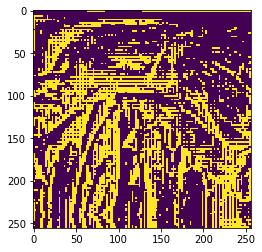

In [46]:
plt.imshow(processed_left[:,:,1,1])

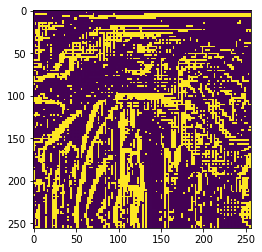

In [48]:
plt.imshow(processed_left[:,:,1,2])

In [47]:
processed_left[0:10, 150, 1, 1]

array([255, 255,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

In [39]:
digitalised = np.digitize(processed_left[:,:,1,1], [0, 2, 127])-1

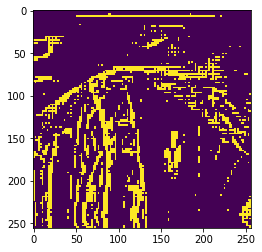

In [40]:
plt.imshow(digitalised)

In [43]:
digitalised

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]])

Interestingly - fast movements of a similar magnitude lightness do not show up anyway at the lower-resolution scales - this naturally leads towards the smoothing in time.

In [ ]:
normalise(processed_left[:,:,1,0])

In [ ]:
processed_left[:,:,1,0].min()

In [ ]:
processed_left[:,:,1,0].max()

## Differences and Time Filtering

What are the dynamic ranges of the differences?
Can we get a better visualisation?
How to model positive and negative differences?
What happens if we set all positive differences as +1 and all negative differences as -1?
How do the differences range over time?